# Introduction
In this competition, you must create an algorithm to identify metastatic cancer in small image patches taken from larger digital pathology scans. The data for this competition is a slightly modified version of the PatchCamelyon (PCam) benchmark dataset. 

The objective of this study is to understand and implement different CNN models to correctly identify images from a dataset of tens of thousands of medical images. In the end, we will compare the result between different CNN models.  

This is a competition on Kaggle at the following link https://www.kaggle.com/competitions/histopathologic-cancer-detection/overview. This competition is evaluated on the categorization accuracy of your predictions (the percentage of images you get correct).

## Description of dataset
In this dataset, you are provided with a large number of small pathology images to classify. Files are named with an image id. The train_labels.csv file provides the ground truth for the images in the train folder. You are predicting the labels for the images in the test folder. A positive label indicates that the center 32x32px region of a patch contains at least one pixel of tumor tissue. Tumor tissue in the outer region of the patch does not influence the label. This outer region is provided to enable fully-convolutional models that do not use zero-padding, to ensure consistent behavior when applied to a whole-slide image.

## Obtaining the dataset
You can download the dataset from Kaggle at following link https://www.kaggle.com/competitions/histopathologic-cancer-detection/data
<br>
There are 2 files:  
<br>
train_labels.csv - the training set contains files id and labels of train set  
sample_submission.csv - a sample submission file in the correct format  
<br>
There are 2 folders:
test folder - contains test images
train folder - contains train images
<br>
The size total about 8Gb.

## Libraries Import

In [1]:
import tensorflow as tf 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import glob
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input,Conv2D, MaxPooling2D, Flatten, Dense, Dropout, UpSampling2D, Concatenate, BatchNormalization, GlobalAveragePooling2D, Activation, AveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping

# Exploratory Data Analysis (EDA)

In [2]:
df = pd.read_csv('data/histopathologic-cancer-detection/train_labels.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB


There are about 220025 images in the train folder with file ids and labels from the train_labels csv file.

In [3]:
df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


The ids are the filenames without the extension '.tif' while the labels are binary which indicate 0 for negative and 1 for positive.

<Axes: xlabel='label', ylabel='count'>

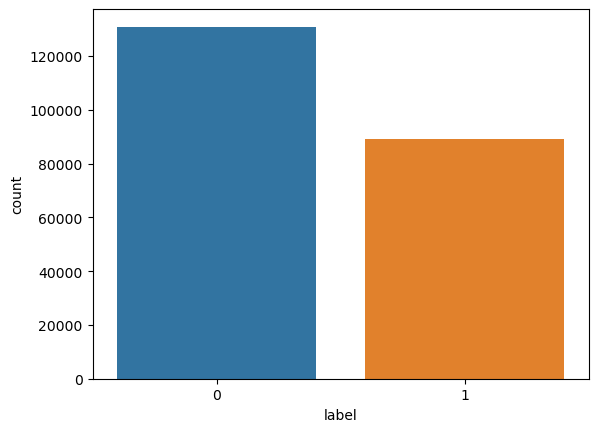

In [4]:
sns.countplot(x = 'label', data= df)

In [47]:
df['label'].value_counts()

0    130908
1     89117
Name: label, dtype: int64

There are 130908 image files that are labeled as negative while there are 89117 image files that are labeled as positive. We can see the ratio of negative cases is roughly 59% of the training set while the ratio of positive cases is 41% of the training set. So we do not have a balanced dataset here but it is not too unbalanced.

In [5]:
img_path = 'data/histopathologic-cancer-detection/train/'
file_list = [df['id'][i] for i in range(df.shape[0])]
file_path_list = [img_path + i + '.tif' for i in file_list]
labels = df['label'].values
ds_files_labels = tf.data.Dataset.from_tensor_slices((file_path_list,labels))

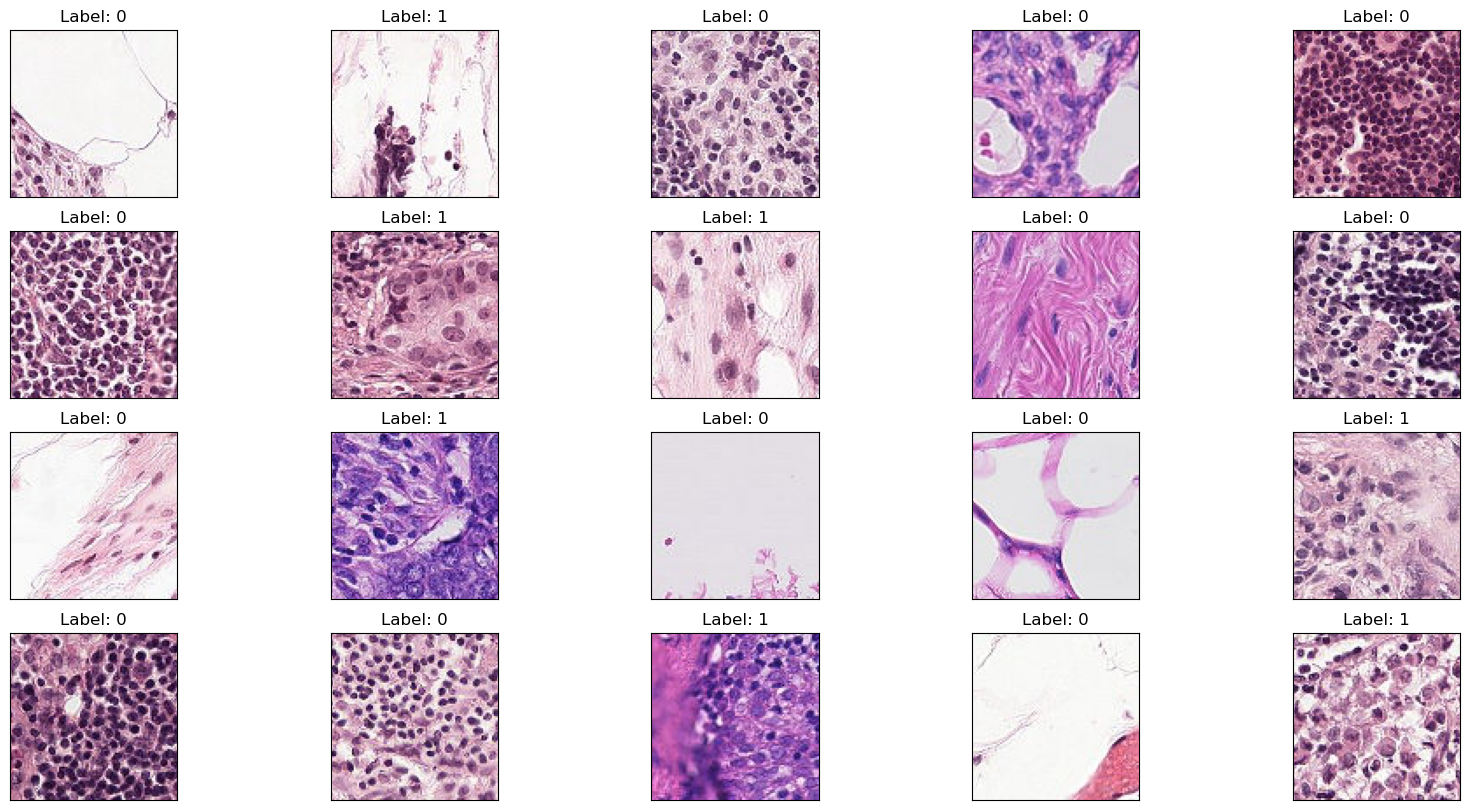

In [6]:
fig = plt.figure(figsize=(20,10))
i = 1;
for item in ds_files_labels.take(20):
    ax = fig.add_subplot(4,5, i, xticks=[], yticks=[])
    img = Image.open(item[0].numpy())
    plt.imshow(img)
    label = item[1].numpy()
    ax.set_title(f'Label: {label}') 
    i+=1
plt.show()

These are the first 20 images taken from the training set with their labels. To be honest, we do not how how those images are labeled are either positive or negative unless we are MDs. 

## Data Preparation
Since we have images from train folder, we need to create a training dataset to load those images and their labels. Keras libaray has a class called ImageDataGenerator that can import images from folders. Here I used flow_from_dataframe where I already have filenames and their labels. All I needed is to specify the exact paths that contain those images. So I created another column named 'path' in my dataframe that contains the exact path for each file in the train folder. For my training purpose, I decided to import all the files from train folder to use as both training and validation set. The reason I did not make the training set or validation set 50%/50% for each label (the dataset is 59%/41%) because I believed the not so unbalanced data would not affect our model that much. And more training examples I included in the training and validation set, the better my model would learn and predict. Unless the dataset is too unbalanced like 70%/30% then I might approach differently. And for the size of training set and validation set, I made it 80/20 (80% for the training,20% for the validation). I did not make the test set because we already had the test folder where I can test my models and submitted on Kaggle for evaluation.

In [7]:
datagen = ImageDataGenerator(rescale=1.0 / 255, validation_split =0.2)

In [8]:
image_size = (96, 96)
batch_size = 32
# Convert numeric labels to strings
df['label'] = df['label'].astype(str)
df['path'] = file_path_list
df

,id,label,path
0,f38a6374c348f90b587e046aac6079959adf3835,0,data/histopathologic-cancer-detection/train/f3...
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1,data/histopathologic-cancer-detection/train/c1...
2,755db6279dae599ebb4d39a9123cce439965282d,0,data/histopathologic-cancer-detection/train/75...
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0,data/histopathologic-cancer-detection/train/bc...
4,068aba587a4950175d04c680d38943fd488d6a9d,0,data/histopathologic-cancer-detection/train/06...
...,...,...,...
220020,53e9aa9d46e720bf3c6a7528d1fca3ba6e2e49f6,0,data/histopathologic-cancer-detection/train/53...
220021,d4b854fe38b07fe2831ad73892b3cec877689576,1,data/histopathologic-cancer-detection/train/d4...
220022,3d046cead1a2a5cbe00b2b4847cfb7ba7cf5fe75,0,data/histopathologic-cancer-detection/train/3d...
220023,f129691c13433f66e1e0671ff1fe80944816f5a2,0,data/histopathologic-cancer-detection/train/f1...


Specify our batch size contains 32 images for each batch. The iamge size is 96*96 pixels with RGB colors.

In [9]:
train_generator = datagen.flow_from_dataframe(
    dataframe = df,
    x_col = 'path',
    y_col = 'label',
    target_size=image_size,     
    batch_size=batch_size,     
    subset = 'training',
    class_mode='binary'   
)

Found 176020 validated image filenames belonging to 2 classes.


I have imported successfully 176020 images for the training set.

In [10]:
valid_generator = datagen.flow_from_dataframe(
    dataframe = df,
    x_col = 'path',
    y_col = 'label',
    target_size=image_size,     
    batch_size=batch_size,      
    subset = 'validation',
    class_mode='binary'    
)

Found 44005 validated image filenames belonging to 2 classes.


I have imported successfully 44005 images for validation set.

# Models Training

## Simple Convo-Convo-Maxpool Model
Since the image is 96*96*3, which is not a great complexed training object, I decided to used convo-convo-maxpool model that is used very frequently in CNN architecture. Here I made a simple model that has 3 convo-convo-maxpool layer blocks. In each block, I used the increasing number of feature maps with same padding, kernel size of (3,3). Since I do not have a very balanced dataset, it might be useful to normalize or regularize our data by batch normalization. Therefore after each convoution layer I would add batch normalization. In the end I just use dense layer with sigmoid activation for model output. 

In [11]:
def simple_ccm(input_size=(96, 96, 3)):
    inputs = Input(input_size)
    
    # Convolutional layers
    x = inputs
    
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(48, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    
    x = Conv2D(48, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(96, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model


In [12]:
# Create model
ccm_model = simple_ccm()

# Compile the model
ccm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Summary of the model architecture
ccm_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 96, 96, 16)        448       
                                                                 
 batch_normalization (Batch  (None, 96, 96, 16)        64        
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 96, 96, 32)        4640      
                                                                 
 batch_normalization_1 (Bat  (None, 96, 96, 32)        128       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 48, 48, 32)        0     

The summary of the model is above. For the opotimizer I used Adam method. And for loss function, binary cross entropy would be our choice since output is binary. 

In [13]:
# Define the EarlyStopping callback to stop training when the validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [14]:
# Create a ModelCheckpoint callback to save the best model
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_ccm_model.h5',
    monitor='val_loss',  
    mode='min',              
    save_best_only=True,     
    save_weights_only=False, 
    verbose=1
)

I defined and created early stopping in order to avoid overfitting when validation loss stops improving. Here training will stop if validation loss does not improve after 5 epochs consecutively. Let's go ahead and train our model.

In [15]:
# Fit the model to the data using the generators and the EarlyStopping and ModelCheckpoint callbacks
epochs = 20  
history_ccm = ccm_model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=epochs,
    callbacks=[early_stopping, checkpoint_callback]  
)

Epoch 1/20
3725/5501 [===================>..........] - ETA: 7:36 - loss: 0.3367 - accuracy: 0.8562

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



5501/5501 [==============================] - ETA: 0s - loss: 0.0590 - accuracy: 0.9786
Epoch 19: val_loss did not improve from 0.12704
5501/5501 [==============================] - 1440s 262ms/step - loss: 0.0590 - accuracy: 0.9786 - val_loss: 0.4242 - val_accuracy: 0.8816
Epoch 20/20
4223/5501 [======================>.......] - ETA: 5:18 - loss: 0.0574 - accuracy: 0.9796

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Training is completed after 20 epochs. Let's draw the plot for training and validation loss as well as training ans validation accuracy in order to see how the first model learns.

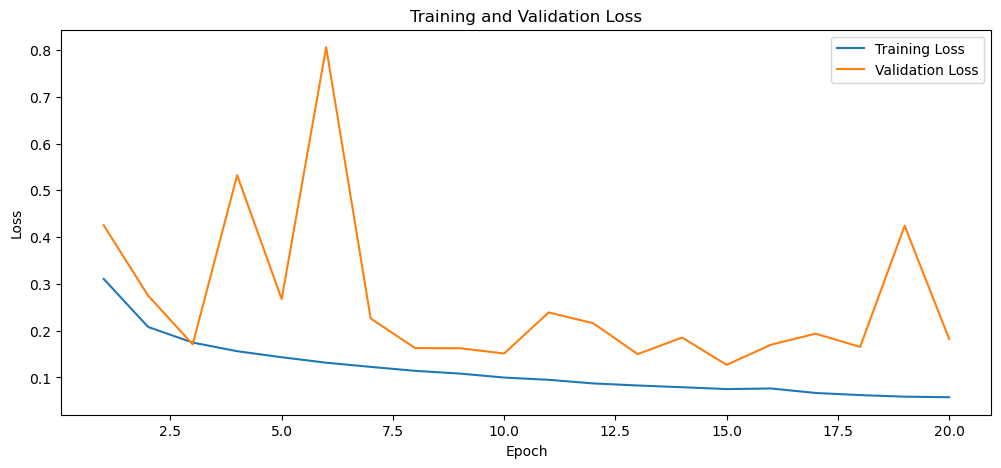

In [16]:
# Extract the training and validation loss from the history object
train_loss = history_ccm.history['loss']
val_loss = history_ccm.history['val_loss']

# Create the plot
plt.figure(figsize=(12,5))

plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')

# Add labels and title
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Show the plot
plt.show()

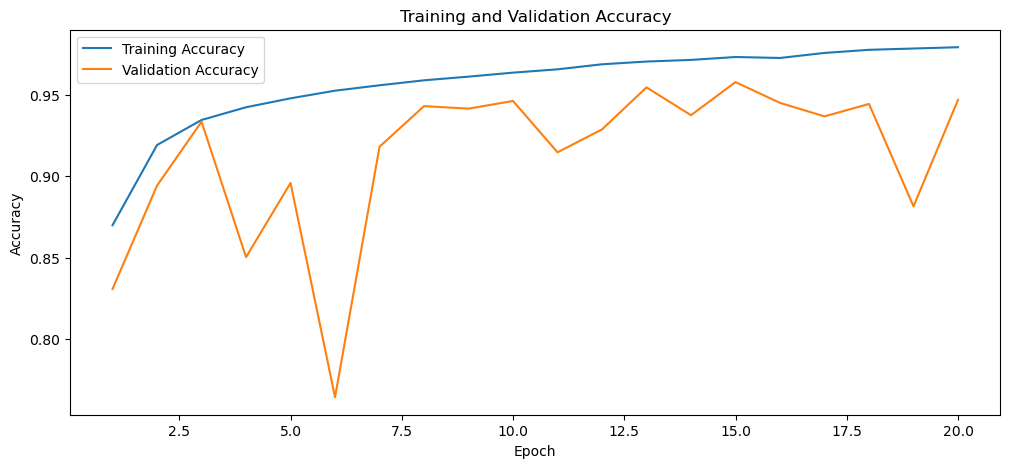

In [17]:
# Extract the training and validation loss from the history object
train_accuracy = history_ccm.history['accuracy']
val_accuracy = history_ccm.history['val_accuracy']

# Create the plot
plt.figure(figsize=(12,5))
plt.plot(range(1, len(train_accuracy) + 1), train_accuracy, label='Training Accuracy')
plt.plot(range(1, len(val_accuracy) + 1), val_accuracy, label='Validation Accuracy')

# Add labels and title
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Show the plot
plt.show()

In [20]:
best_ccm_model = tf.keras.models.load_model('best_ccm_model.h5')

valid_loss, valid_accuracy = best_ccm_model.evaluate(valid_generator)
print("Validation Loss For Best CCM Model:", valid_loss)
print("Valid Accuracy For Best CCM Model:", valid_accuracy)

1376/1376 [==============================] - 79s 57ms/step - loss: 0.1270 - accuracy: 0.9580
Validation Loss For Best CCM Model: 0.12703837454319
Valid Accuracy For Best CCM Model: 0.9579592943191528


Looking at those plots above,  I could tell that our model has the highest validation accuracy and lowest validation loss at epoch = 15. The loss is about 0.127 and the accuracy achieved on the validation set is roughly 95.8%. Let's do some fine tuning for the first model.

### Hyperparameters Tuning
I will unfreeze some layers for fine tuning, and I also adjusted the learning rate from 0.001 to 0.0001. Then I will fit another 5 epochs from the best model for fine tuning.

In [21]:
# Unfreeze some layers for fine-tuning
for layer in best_ccm_model.layers:
    layer.trainable = True

# Compile the best model again with a lower learning rate for fine-tuning
best_ccm_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Fit the best model to the data again for fine-tuning
fine_tune_epochs = 5  
history_fine_tune = best_ccm_model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=fine_tune_epochs,
    callbacks=[checkpoint_callback]
)

Epoch 1/5
5501/5501 [==============================] - ETA: 0s - loss: 0.0459 - accuracy: 0.9842
Epoch 1: val_loss improved from 0.12704 to 0.12155, saving model to best_ccm_model.h5
5501/5501 [==============================] - 1501s 273ms/step - loss: 0.0459 - accuracy: 0.9842 - val_loss: 0.1215 - val_accuracy: 0.9624
Epoch 2/5
5501/5501 [==============================] - ETA: 0s - loss: 0.0363 - accuracy: 0.9877
Epoch 2: val_loss did not improve from 0.12155
5501/5501 [==============================] - 1434s 261ms/step - loss: 0.0363 - accuracy: 0.9877 - val_loss: 0.1329 - val_accuracy: 0.9617
Epoch 3/5
5501/5501 [==============================] - ETA: 0s - loss: 0.0328 - accuracy: 0.9889
Epoch 3: val_loss did not improve from 0.12155
5501/5501 [==============================] - 1435s 261ms/step - loss: 0.0328 - accuracy: 0.9889 - val_loss: 0.1344 - val_accuracy: 0.9623
Epoch 4/5
5501/5501 [==============================] - ETA: 0s - loss: 0.0292 - accuracy: 0.9901
Epoch 4: val_loss 

In [22]:
best_ccm_model = tf.keras.models.load_model('best_ccm_model.h5')
valid_loss_list = []
valid_acccuracy_list = []
valid_loss, valid_accuracy = best_ccm_model.evaluate(valid_generator)
valid_loss_list.append(valid_loss)
valid_acccuracy_list.append(valid_accuracy)
print("Validation Loss After Tuning:", valid_loss)
print("Validation Accuracy After Tuning:", valid_accuracy)

1376/1376 [==============================] - 74s 53ms/step - loss: 0.1215 - accuracy: 0.9624
Validation Loss After Tuning: 0.12154894322156906
Validation Accuracy After Tuning: 0.962390661239624


After hyperparameters tuning, the best model is able to achieve accuracy of 96.24% and loss of 0.1215 on the validation set. 

### Test Set Evaluation
In order to test our model on the test set, I needed to create a test dataset from the test folder. Using ImageDataGenerator class from Keras, I was able to have the test set ready for evaluation.

In [23]:
df_test = pd.read_csv('data/histopathologic-cancer-detection/sample_submission.csv')
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57458 entries, 0 to 57457
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      57458 non-null  object
 1   label   57458 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 897.9+ KB


In [24]:
test_img_path = 'data/histopathologic-cancer-detection/test/'
test_file_list = [df_test['id'][i] for i in range(df_test.shape[0])]
test_file_path_list = [test_img_path + i + '.tif' for i in test_file_list]

df_test['label'] = df_test['label'].astype(str)
df_test['path'] = test_file_path_list

test_datagen = ImageDataGenerator(rescale=1 / 255.0)
test_generator = test_datagen.flow_from_dataframe(
    dataframe = df_test,
    x_col = 'path',
    y_col = None,
    target_size=(96,96), 
    class_mode = None,
    batch_size=1, 
    shuffle = False
)

Found 57458 validated image filenames.


I have successfully imported 527458 images from the test folder as test dataset. Now it's time to make predictions on the dataset and submit it on Kaggle for evaluation.

In [25]:
ccm_predictions = best_ccm_model.predict(test_generator, verbose=1)

57458/57458 [==============================] - 327s 6ms/step


In [26]:
ccm_predictions.shape

(57458, 1)

In [27]:
def test_submit(y_pred, filename):
    try:
        submit_df = df_test
        submit_df['label'] = y_pred
        submit_df = submit_df.drop(['path'], axis =1)
        submit_df.to_csv(filename, index=False)
        print('File saved to ',filename)
    except:
        print('Error trying to create ', filename)

In [28]:
ccm_y_pred = ccm_predictions[:,0]
ccm_y_pred

array([2.0755581e-03, 3.9115778e-01, 1.5757713e-04, ..., 1.1106663e-03,
       1.8737995e-04, 6.7340187e-03], dtype=float32)

In [30]:
test_submit(ccm_y_pred,'cancer_dectection_submission.csv')
print('Test Accuracy for Convo-Convo-Maxpool: 0.9492')

File saved to  cancer_dectection_submission.csv
Test Accuracy for Convo-Convo-Maxpool: 0.9492


**After submitting the file on Kagge for evaluation, Kaggle reported the test accuracy is 94.92% for the first model.** 

## Simple DenseNet Model
DenseNet is a deep convolutional neural network architecture that was introduced in the paper "Densely Connected Convolutional Networks" by Gao Huang, Zhuang Liu, Laurens van der Maaten, and Kilian Q. Weinberger in 2016. DenseNet is known for its unique architecture that promotes dense connectivity between layers, allowing each layer to receive direct inputs from all previous layers.  
The DenseNet architecture consists of multiple dense blocks, each containing several layers. Within each dense block, feature maps from all previous layers are concatenated and passed as input to the subsequent layers.  

More details is discussed in the paper which from the link https://arxiv.org/abs/1608.06993v5   
I decided to create a simple DensetNet model instead of using the transfer learning from exisiting DenseNet model such as DensetNet161 or DenseNet121 which may be a bit too much for this dataset. The simple architecture of DenseNet can be applied from the following Github codes: https://github.com/pytorch/vision/blob/6db1569c89094cf23f3bc41f79275c45e9fcb3f3/torchvision/models/densenet.py#L126

In [35]:
def dense_block(x, num_layers, growth_rate):
    for _ in range(num_layers):
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Conv2D(growth_rate, (3, 3), padding='same')(x)
        x = Concatenate()([x, x])
    return x

def transition_block(x, compression_factor):
    num_channels = int(x.shape[-1] * compression_factor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(num_channels, (1, 1))(x)
    x = AveragePooling2D((2, 2))(x)
    return x

def densenet(input_shape, num_blocks=2, num_layers_per_block=2, growth_rate=32, compression_factor=0.5):
    inputs = tf.keras.layers.Input(shape=input_shape)

    # Initial convolutional layer
    x = Conv2D(32, (3, 3), strides=(1, 1), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    # Dense blocks and transition blocks
    for i in range(num_blocks):
        x = dense_block(x, num_layers_per_block, growth_rate)
        x = transition_block(x, compression_factor)

    # Final block
    x = GlobalAveragePooling2D()(x)

    # Output layer
    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

In [36]:
dense_model = densenet(input_shape=(96, 96, 3))

# Compile the model
dense_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
dense_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 96, 96, 3)]          0         []                            
                                                                                                  
 conv2d_24 (Conv2D)          (None, 96, 96, 32)           896       ['input_3[0][0]']             
                                                                                                  
 batch_normalization_25 (Ba  (None, 96, 96, 32)           128       ['conv2d_24[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_16 (Activation)  (None, 96, 96, 32)           0         ['batch_normalization_25

  (GlobalAveragePooling2D)                                                                        
                                                                                                  
 dense_3 (Dense)             (None, 1)                    33        ['global_average_pooling2d_1[0
                                                                    ][0]']                        
                                                                                                  
Total params: 61921 (241.88 KB)
Trainable params: 61217 (239.13 KB)
Non-trainable params: 704 (2.75 KB)
__________________________________________________________________________________________________


In [33]:
# Create a ModelCheckpoint callback to save the best model
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_dense_model.h5',
    monitor='val_loss',  
    mode='min',              
    save_best_only=True,     
    save_weights_only=False, 
    verbose=1
)

The summary of my simple DensetNet model is above. I also need another checkpoint callback to save my best model for training. Let's do some training for the second model.

In [37]:
# Fit the model to the data using the generators and the EarlyStopping and ModelCheckpoint callbacks
epochs = 20  
history_dense = dense_model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=epochs,
    callbacks=[early_stopping, checkpoint_callback]  
)

Epoch 1/20
5501/5501 [==============================] - ETA: 0s - loss: 0.3239 - accuracy: 0.8632
Epoch 1: val_loss improved from inf to 0.37811, saving model to best_dense_model.h5
5501/5501 [==============================] - 1614s 293ms/step - loss: 0.3239 - accuracy: 0.8632 - val_loss: 0.3781 - val_accuracy: 0.8327
Epoch 2/20


C:\Users\Admin\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


5501/5501 [==============================] - ETA: 0s - loss: 0.2362 - accuracy: 0.9074
Epoch 2: val_loss improved from 0.37811 to 0.25805, saving model to best_dense_model.h5
5501/5501 [==============================] - 1495s 272ms/step - loss: 0.2362 - accuracy: 0.9074 - val_loss: 0.2581 - val_accuracy: 0.8998
Epoch 3/20
5501/5501 [==============================] - ETA: 0s - loss: 0.2047 - accuracy: 0.9219
Epoch 3: val_loss did not improve from 0.25805
5501/5501 [==============================] - 1503s 273ms/step - loss: 0.2047 - accuracy: 0.9219 - val_loss: 0.4439 - val_accuracy: 0.8508
Epoch 4/20
5501/5501 [==============================] - ETA: 0s - loss: 0.1875 - accuracy: 0.9295
Epoch 4: val_loss improved from 0.25805 to 0.19744, saving model to best_dense_model.h5
5501/5501 [==============================] - 1505s 274ms/step - loss: 0.1875 - accuracy: 0.9295 - val_loss: 0.1974 - val_accuracy: 0.9230
Epoch 5/20
5501/5501 [==============================] - ETA: 0s - loss: 0.1752 -

Training for my DenseNet Model completeed after 20 epochs. Let's plot the training and validation loss as well as accuracy for better visualization.

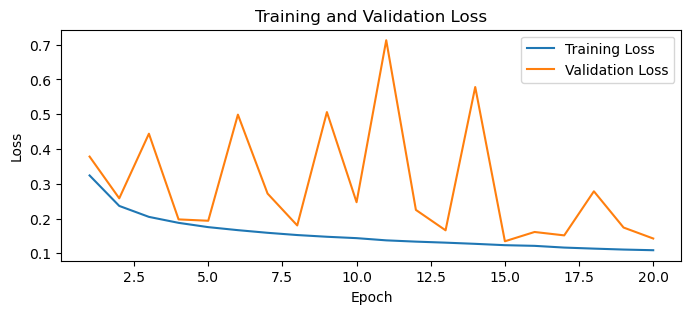

In [38]:
# Extract the training and validation loss from the history object
train_loss = history_dense.history['loss']
val_loss = history_dense.history['val_loss']

# Create the plot
plt.figure(figsize=(8,3))
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
# Add labels and title
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Show the plot
plt.show()

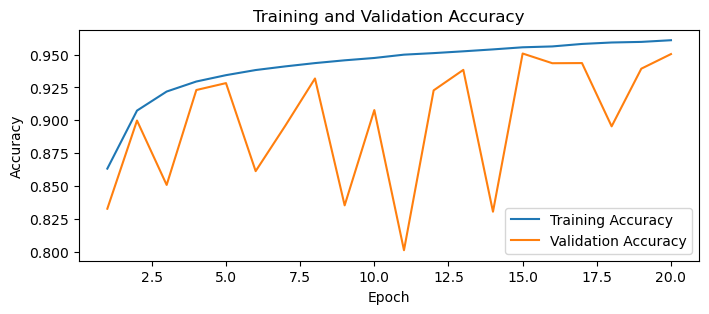

In [39]:
# Extract the training and validation loss from the history object
train_accuracy = history_dense.history['accuracy']
val_accuracy = history_dense.history['val_accuracy']

# Create the plot
plt.figure(figsize=(8,3))
plt.plot(range(1, len(train_accuracy) + 1), train_accuracy, label='Training Accuracy')
plt.plot(range(1, len(val_accuracy) + 1), val_accuracy, label='Validation Accuracy')

# Add labels and title
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Show the plot
plt.show()

In [40]:
best_dense_model = tf.keras.models.load_model('best_dense_model.h5')

valid_loss, valid_accuracy = best_dense_model.evaluate(valid_generator)
print("Validation Loss For Best Dense Model:", valid_loss)
print("Valid Accuracy For Best Dense Model:", valid_accuracy)

1376/1376 [==============================] - 86s 63ms/step - loss: 0.1345 - accuracy: 0.9508
Validation Loss For Best Dense Model: 0.1345330774784088
Valid Accuracy For Best Dense Model: 0.9508010745048523


Again, the plots showed that the second model has the lowest loss and highest accuracy at epoch = 15. Our best model after training gave 0.1345 for validation loss and 95.08% for validation accuracy.

### Hyperparameters Tuning
I unfreezed some layers for fine tuning, and I also adjusted the learning rate from 0.001 to 0.0001. Then I fitted another 5 epochs from the best model for fine tuning.

In [41]:
# Unfreeze some layers for fine-tuning
for layer in best_dense_model.layers:
    layer.trainable = True

# Compile the best model again with a lower learning rate for fine-tuning
best_dense_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Fit the best model to the data again for fine-tuning
fine_tune_epochs = 5  
history_fine_tune = best_dense_model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=fine_tune_epochs,
    callbacks=[checkpoint_callback]
)

Epoch 1/5
5501/5501 [==============================] - ETA: 0s - loss: 0.0982 - accuracy: 0.9653
Epoch 1: val_loss improved from 0.13453 to 0.11183, saving model to best_dense_model.h5
5501/5501 [==============================] - 1552s 282ms/step - loss: 0.0982 - accuracy: 0.9653 - val_loss: 0.1118 - val_accuracy: 0.9613
Epoch 2/5
5501/5501 [==============================] - ETA: 0s - loss: 0.0942 - accuracy: 0.9670
Epoch 2: val_loss did not improve from 0.11183
5501/5501 [==============================] - 1501s 273ms/step - loss: 0.0942 - accuracy: 0.9670 - val_loss: 0.1168 - val_accuracy: 0.9593
Epoch 3/5
5501/5501 [==============================] - ETA: 0s - loss: 0.0918 - accuracy: 0.9680
Epoch 3: val_loss did not improve from 0.11183
5501/5501 [==============================] - 1496s 272ms/step - loss: 0.0918 - accuracy: 0.9680 - val_loss: 0.1218 - val_accuracy: 0.9587
Epoch 4/5
5501/5501 [==============================] - ETA: 0s - loss: 0.0898 - accuracy: 0.9684
Epoch 4: val_los

In [42]:
best_dense_model = tf.keras.models.load_model('best_dense_model.h5')
valid_loss, valid_accuracy = best_dense_model.evaluate(valid_generator)
valid_loss_list.append(valid_loss)
valid_acccuracy_list.append(valid_accuracy)
print("Validation Loss After Tuning:", valid_loss)
print("Valid Accuracy After Tuning:", valid_accuracy)

1376/1376 [==============================] - 86s 62ms/step - loss: 0.1118 - accuracy: 0.9613
Validation Loss After Tuning: 0.11183495074510574
Valid Accuracy After Tuning: 0.9612998366355896


After hyperparameters tuning, the best for second model is able to achieve accuracy of 96.13% and loss of 0.1118 on the validation set. Now it's time to make predictions on our test set.

### Test Set Evaluation

In [43]:
dense_predictions = best_dense_model.predict(test_generator, verbose=1)

57458/57458 [==============================] - 334s 6ms/step


In [44]:
dense_predictions.shape

(57458, 1)

In [45]:
dense_y_pred = dense_predictions[:,0]
dense_y_pred

array([0.02999921, 0.03101303, 0.00098751, ..., 0.00045859, 0.00296086,
       0.00362051], dtype=float32)

In [48]:
test_submit(dense_y_pred,'cancer_dectection_submission.csv')
print('Test Accuracy for Simple DenseNet Model: 0.9508')

File saved to  cancer_dectection_submission.csv
Test Accuracy for Simple DenseNet Model: 0.9508


**After submitting the file on Kagge for evaluation, Kaggle reported the test accuracy is 95.08% for the second model.** 

# Result, Analysis and Discussion 

In [51]:
test_accuracy_list = [0.9492,0.9508]
data = {'Validation Accuracy': valid_acccuracy_list, 'Validation Loss': valid_loss_list, 'Test Accuracy':test_accuracy_list}
result_df = pd.DataFrame(data)
result_df.index = ['Convo-Convo-Maxpool', 'Simple DenseNet']
print('Model Results Comparision Table')
result_df

Model Results Comparision Table


,Validation Accuracy,Validation Loss,Test Accuracy
Convo-Convo-Maxpool,0.962391,0.121549,0.9492
Simple DenseNet,0.961300,0.111835,0.9508


***The table shows that a simple convolutional neural network such as a simple convo-convo-maxpool model can correctly predict 94.92% on the test set. Meanwhile, a more compled model like DenseNet (though was implemented in a much simple way ) can label the data correctly 95.08% on the test set. This shows that for such a dataset like this one, a simple CNN model surely can do the job very well after training. But in order to achieve an almost perfect score on accuracy (like 0.98 to 1), maybe we have to design a more complexed model or use transfer learning models to do the job. However a more complexed model means more training time for each epoch or the overall training time will be much more than these simple ones. That we have to take into consideration.*** 

## Sources
- Densely Connected Convolutional Networks by Gao Huang, Zhuang Liu, Laurens van der Maaten, Kilian Q. Weinberger, submitted on 25 Aug 2016 (v1), last revised 28 Jan 2018. https://arxiv.org/abs/1608.06993
- Implementation of simple DensetNet from https://github.com/pytorch/vision/blob/6db1569c89094cf23f3bc41f79275c45e9fcb3f3/torchvision/models/densenet.py#L126